# Image Classification of Dogs and Cats using SVM

In [64]:
#Import libraries
import os
import zipfile
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [49]:
#Paths
ZIP_PATH = r"D:\MY FOLDER\jupyter\SKILLCRAFT\Support vector machine\train.zip"
EXTRACT_DIR = r"D:\MY FOLDER\jupyter\SKILLCRAFT\Support vector machine\train"
IMG_SIZE = 160
N_SAMPLES = 500

# Extract dataset

In [51]:
if not os.path.exists(EXTRACT_DIR):
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_DIR)
    print("Extraction done.")
else:
    print("Train folder already exists.")

Train folder already exists.


# Detect all images

In [52]:
image_files = []
for root, dirs, files in os.walk(EXTRACT_DIR):
    for f in files:
        if f.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_files.append(os.path.join(root, f))
print(f"Total images found: {len(image_files)}")
if len(image_files) == 0:
    raise FileNotFoundError("No image files found in the extracted folder.")

Total images found: 25000


# Separate cat and dog images

In [53]:
cat_images = [f for f in image_files if 'cat' in os.path.basename(f).lower()]
dog_images = [f for f in image_files if 'dog' in os.path.basename(f).lower()]
print(f"Found {len(cat_images)} cat images and {len(dog_images)} dog images")

Found 12500 cat images and 12500 dog images


# Balanced subsampling

In [54]:
cat_images = random.sample(cat_images, min(len(cat_images), N_SAMPLES))
dog_images = random.sample(dog_images, min(len(dog_images), N_SAMPLES))
print(f"After subsampling: {len(cat_images)} cats, {len(dog_images)} dogs")

After subsampling: 500 cats, 500 dogs


# Load images and labels

In [55]:
X, y = [], []

for path in cat_images:
    try:
        img = load_img(path, target_size=(IMG_SIZE, IMG_SIZE))
        img = img_to_array(img)
        img = preprocess_input(img)
        X.append(img)
        y.append(0)
    except:
        continue

for path in dog_images:
    try:
        img = load_img(path, target_size=(IMG_SIZE, IMG_SIZE))
        img = img_to_array(img)
        img = preprocess_input(img)
        X.append(img)
        y.append(1)
    except:
        continue

X = np.array(X)
y = np.array(y)
print("Dataset loaded:", X.shape, y.shape)

Dataset loaded: (1000, 160, 160, 3) (1000,)


# Data Visualization

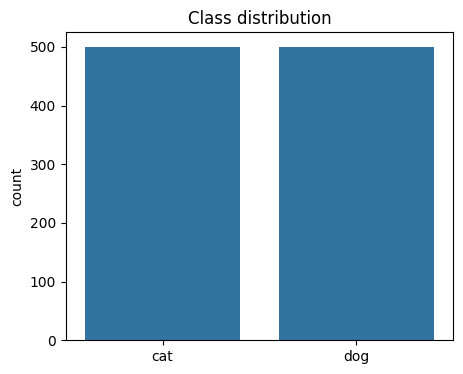

In [56]:
# 1. Show class distribution
plt.figure(figsize=(5,4))
sns.countplot(x=y)
plt.xticks([0,1], ["cat", "dog"])
plt.title("Class distribution")
plt.show()

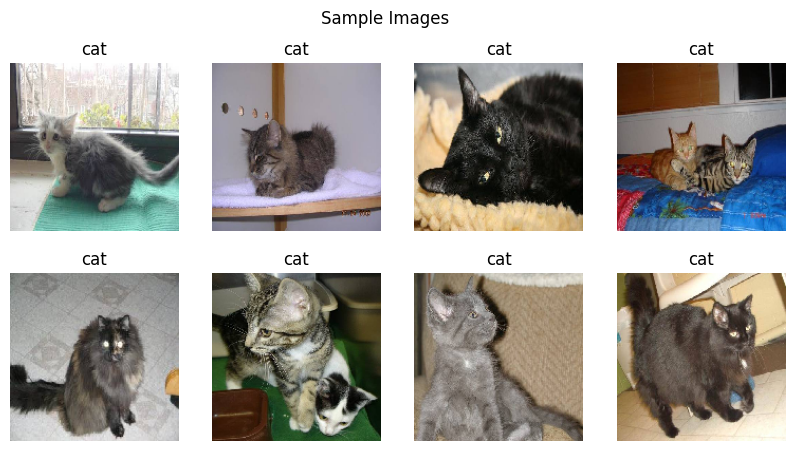

In [57]:
# 2. Show a few sample images
plt.figure(figsize=(10,5))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow((X[i] + 1) / 2)  # undo preprocess_input normalization
    label = "cat" if y[i]==0 else "dog"
    plt.title(label)
    plt.axis('off')
plt.suptitle("Sample Images")
plt.show()

# Feature Extraction (MobileNetV2)

In [58]:
ase_model = MobileNetV2(weights="imagenet", include_top=False, pooling="avg", input_shape=(IMG_SIZE, IMG_SIZE, 3))
features = base_model.predict(X, batch_size=32, verbose=1)
print("Features shape:", features.shape)

32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 468ms/step
Features shape: (1000, 1280)


In [59]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(features, y, test_size=0.2, random_state=42, stratify=y)

# Train SVM Classifier

In [60]:
svm = SVC(kernel="linear", probability=True, random_state=42)
svm.fit(X_train, y_train)

,C,1.0
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


# Evaluate

In [63]:
y_pred = svm.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc*100:.2f}%")
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=["cat", "dog"]))

Test Accuracy: 96.50%

Classification Report:
               precision    recall  f1-score   support

         cat       0.97      0.96      0.96       100
         dog       0.96      0.97      0.97       100

    accuracy                           0.96       200
   macro avg       0.97      0.96      0.96       200
weighted avg       0.97      0.96      0.96       200



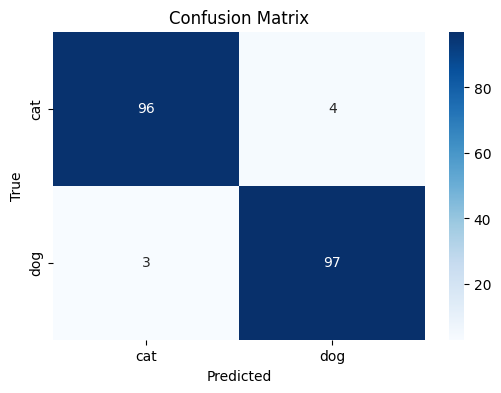

In [62]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["cat", "dog"], yticklabels=["cat", "dog"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()